# Optics of the *M. amalphitanum* eye
- View ommatidia measurements from AM and team 
- Calculate optical parameters from physical measurements
- Perform clustering on these physical features, compare with lamina circuit clustering

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

import sys
sys.path.append('..')
from cx_analysis.utils import index_by_om
from cx_analysis.dataframe_tools import assemble_cxvectors
from vis.fig_tools import linear_cmap, subtype_cm
from vis.hex_lattice import hexplot_TEST, hexplot

In [3]:
plt.rcdefaults()
plt.style.use('vis/lamina.mplstyle')
### SAVE FIGS? ###
save_figs=False
##################
# if save_figs:
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/FNAME.svg')
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/FNAME.png')

In [4]:
optics_df = pd.read_excel('~/Data/data for ligh prop.xlsx', index_col=0)
optics_df = optics_df.iloc[:29] # remove last two lines of excel file
# Add pre-computed rhabdom lengths (from rhabdomere_lengths.ipynb)
rh_len = pd.read_pickle('~/Dropbox/Data/201123_rh_len_df.pickle')
for i, v in rh_len.iterrows():
    optics_df.loc[i, 'rhabdom_len'] = float(v)
optics_df.head()

<ipython-input-4-d997583733f0>:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  optics_df = pd.read_excel('~/Data/data for ligh prop.xlsx', index_col=0)


,facet diameter (stack),lense thickness,outer curvature,inner curvature,cone length (from the tip),cone width (under the lense tip),D rhabdom dist.,D rhabdom prox.,rhabdom_len
E7,6.923,2.60900,2.219000,1.059000,3.26300,4.630000,1.782745,1.247685,13.960
E6,6.98073,2.96461,3.075507,1.506532,3.40063,5.523305,2.262045,1.454785,13.352
E5,9.263,3.64300,3.818000,2.765000,4.94300,6.648000,2.417245,2.116145,11.088
E4,8.07757,2.65285,4.636710,3.762965,3.67528,6.701025,2.970095,2.274005,12.704
D7,6.396,2.15800,2.969000,0.926000,2.82000,4.681000,1.917540,1.261355,14.032


## Lens calculations
### Measurements (all $\mu{m}$)
- Lens: Outer radius of curvature, $r_1$
- Lens: Inner radius of curvature, $r_2$
- Lens: thickness, $t$
- Lens: diameter, $D$
- Rhabdom: distal diameter, $D_{Rh}$
- Rhabdom: length, $l_{Rh}$
- Measurements also taken for the length and distal width of the crystalline cone, and the proximal diameter of the rhabdom (not used for the following calculations) 

### Calculations
- We used the refractive indices of the honey bee lens ($n_l$) and crystalline cone ($n_c$), from Valera & Wiitanen (1970)
- Optical power ($\mu{m}^{-1}$) of the diopteric apparatus (lens + crystalline cone), $P$, calculated using the thick lens formula (Fundamentals of Optics, Jenkins & White, p.84, 2001): 
$$P = P_1 + P_2 - \frac{t}{n_l} P_1 P_2$$
    - $P_1 = \frac{n_l - 1.0}{r_1}$, power from outer lens surface
    - $P_2 = \frac{n_c - n_l}{r_2}$, power from inner lens surface  
- Focal length of the object ($\mu{m}$): $f = 1/P$
- Focal length of the image ($\mu{m}$): $f' = {n_c}/P$
- F-number: $F = f/D$
- The acceptance angle of an ommatidium, $\Delta\rho$, is proscribed by diffraction effects at the lens,  $\Delta\rho_l$, and the geometry of the distal rhabdom tip and the lens, $\Delta\rho_{Rh}$ (Snyder, 1979):
$$\Delta\rho = \sqrt{{\Delta\rho_l}^2 + {\Delta\rho_{Rh}}^2}$$
    - $\Delta\rho_l = \lambda/D$, where we set $\lambda$ = 0.5 $\mu{m}$ (green monochromatic light)
    - $\Delta\rho_{Rh} = D_{Rh}/f$
- Optical sensitivity to an extended broadband-spectrum source, $S$ ($\mu{m}^2{sr}$), approximated by:  
$$S = (\frac{\pi}{4})^2 D^2 {\Delta\rho}^2 \frac{k{l}_{Rh}}{2.3 + k{l}_{Rh}}$$
    - See [Fredriksen and Warrant, 2008](https://dx.doi.org/10.1098%2Frsbl.2008.0467); [Kirschfeld, 1974](https://doi.org/10.1515/znc-1974-9-1023)
    - k is the peak absorbtion (length) coefficient of the visual pigment, taken as 0.0067 $\mu{m}^-1$ (Warrant et al., 2004)
    - Notes: facet area is $\frac{\pi{D}^2}{4}$, the fraction of incident light absorbed is $\frac{k{l}_{Rh}}{2.3 + k{l}_{Rh}}$



## TODO: Hypothesis tests between DRA/NDRA distributions

In [5]:
r1 = optics_df['outer curvature']
r2 = -1 * optics_df['inner curvature']
t = optics_df['lense thickness']
D = optics_df['facet diameter (stack)'].astype('float')
Dr = optics_df['D rhabdom dist.']
lr = optics_df['rhabdom_len']

# Refractive indices from Apis mellifera (Varela & Wiitanen 1970)
# n = 1 # air
nl = 1.452 # lens
nc = 1.348 # cone
# lens power IN MICROMETERS
p1 = (nl - 1.0)/r1 # interface air->lens 
p2 = (nc - nl)/r2 # interface lens->cone
p = p1 + p2
# lens power: thick lens equation
# p3 = (t/nl)*p1*p2  # thickness 'correction'
# p_thick = p1 + p2 - p3
# Focal length object and image (n/p)
f = 1.0/(p)
fi = nc/(p)
# Focal length (thick lens eq, total_p = p1+p2-p3)
# f_t = 1.0/p_thick
# fi_t = nc/p_thick
# F-number (ratio of lens diameter to focal length)
F = D/f
# Acceptance angle
rho_l = 0.5/D # angular sens. due to diffraction at the lens, lambda=0.5
rho_rh = Dr/f # angular sens. due to geometry of rhabdom tip
# 'simple' acceptance angle formula 
rho = (rho_l ** (2.0) + rho_rh ** (2.0)) ** (0.5)

# Optical sensitivity
k = 0.0067 # peak absorbtion coefficient (wrt rhabdom length) from Warrant et al., 2004
kl = k * lr
S = ((np.pi / 4.0)**2.0) * (D ** 2.0) * (rho ** 2.0) * (kl / (2.3 + kl))

optics_df['f'] = f.astype('float') 
optics_df['f-image'] = fi.astype('float') 
optics_df['P'] = p.astype('float') 
optics_df['F-number'] = F.astype('float') 
optics_df['rho_l'] = np.degrees(rho_l.astype('float') )
optics_df['rho_rh'] = np.degrees(rho_rh.astype('float') )
optics_df['rho'] = np.degrees(rho.astype('float') )
optics_df['S'] = S.astype('float')  

In [6]:
#dra_om = ['A4', 'A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E6', 'E7']
dra_om = ['A5', 'B5', 'B6', 'C5', 'C6', 'D6', 'D7', 'E7']
ndra_om = [str(o) for o in optics_df.index if o not in dra_om]
regional_summary = pd.DataFrame([optics_df.mean(), optics_df.std(ddof=0), 
                                 optics_df.loc[ndra_om].mean(), optics_df.loc[ndra_om].std(ddof=0), 
                                 optics_df.loc[dra_om].mean(), optics_df.loc[dra_om].std(ddof=0)], 
                                index=['All_mean', 'All_SD', 'NDRA_mean', 'NDRA_SD', 'DRA_mean', 'DRA_SD'])

display(regional_summary.T)

,All_mean,All_SD,NDRA_mean,NDRA_SD,DRA_mean,DRA_SD
facet diameter (stack),7.641780,0.940224,7.996483,0.761348,6.710683,0.696984
lense thickness,3.013373,0.576497,3.274723,0.379002,2.327331,0.421604
outer curvature,4.201836,0.782218,4.562741,0.497373,3.254460,0.573762
inner curvature,2.416195,0.968526,2.909430,0.627310,1.121452,0.229026
cone length (from the tip),4.071292,0.915484,4.514858,0.641932,2.906934,0.290264
cone width (under the lense tip),6.038509,0.955642,6.570335,0.371078,4.642466,0.507627
D rhabdom dist.,2.491623,0.402176,2.684150,0.285367,1.986239,0.140889
D rhabdom prox.,1.892059,0.443813,2.128230,0.256528,1.272109,0.102582
rhabdom_len,14.256000,1.535509,14.455619,1.742167,13.732000,0.447821
f,6.519673,1.645304,7.378023,0.939560,4.266506,0.696356


- Diffraction by the facet lens depends on light wavelength, lens diameter, and its focal distance
- Male blowfly, Calliphora (Stavenga 1990): D=20-40 $\mu{m}$; $f/D$ remains relatively constant despite range of D, giving $F = 2.0{\pm}0.2$ (based on optical measurements); 

## Lens power and rhabdom depth are linearly related
- depth calculated as: 0.5(lens thickness) + cone length

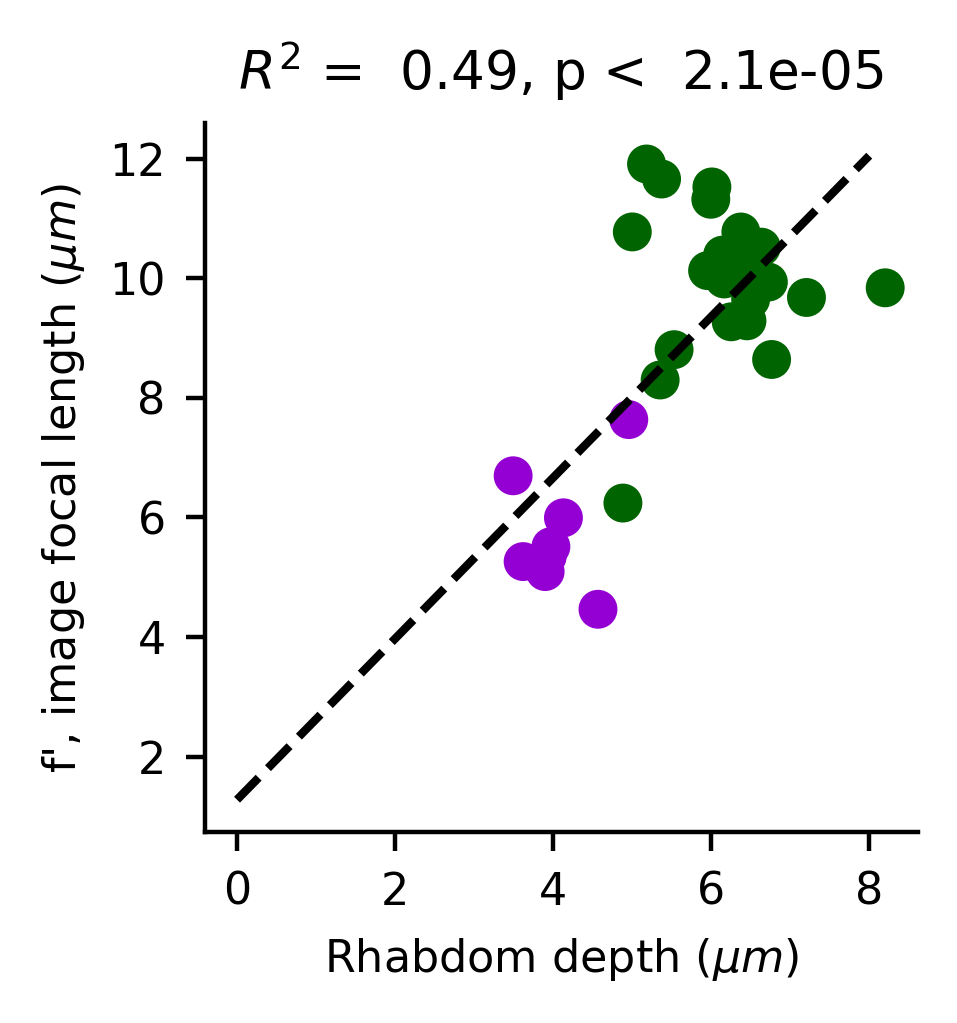

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                f-image   R-squared:                       0.495
Model:                            OLS   Adj. R-squared:                  0.476
Method:                 Least Squares   F-statistic:                     26.43
Date:                Tue, 15 Jun 2021   Prob (F-statistic):           2.08e-05
Time:                        17:00:50   Log-Likelihood:                -54.352
No. Observations:                  29   AIC:                             112.7
Df Residuals:                      27   BIC:                             115.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2817      1.491      0.859      0.398      -1.778       4.342
0              1.3458      0.262      5.141      0.000       0.809       1.883
==============================================================================
Omnibus:                        1.869   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.393   Jarque-Bera (JB):                1.367
Skew:                           0.529   Prob(JB):                        0.505
Kurtosis:                       2.881   Cond. No.                         28.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
_x = optics_df['cone length (from the tip)'] + (0.5*optics_df['lense thickness'])
X = sm.add_constant(_x)
Y = optics_df['f-image']

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

c = []
for om in optics_df.index:
    if om in dra_om:
        c.append('darkviolet')
    else:
        c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c=c, marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel('Rhabdom depth ($\mu{m}$)')
ax.set_ylabel("f', image focal length ($\mu{m}$)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
ax.plot(xx, params['const'] + params[0] * xx, c='k', ls='--')

plt.show()
if save_figs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/focal_rhabdom_scatter_fullscale.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/focal_rhabdom_scatter_fullcale.png')

# SHOW OLS RESULTS
display(results.summary())

# Focal length is also linearly related to the distal diameter of the rhabdom
- $D_{Rh} / f$ approximates the ommatidium's acceptance angle based on the geometry of the lens and rhabdom surface 

const             -3.220830
D rhabdom dist.    4.819891
dtype: float64

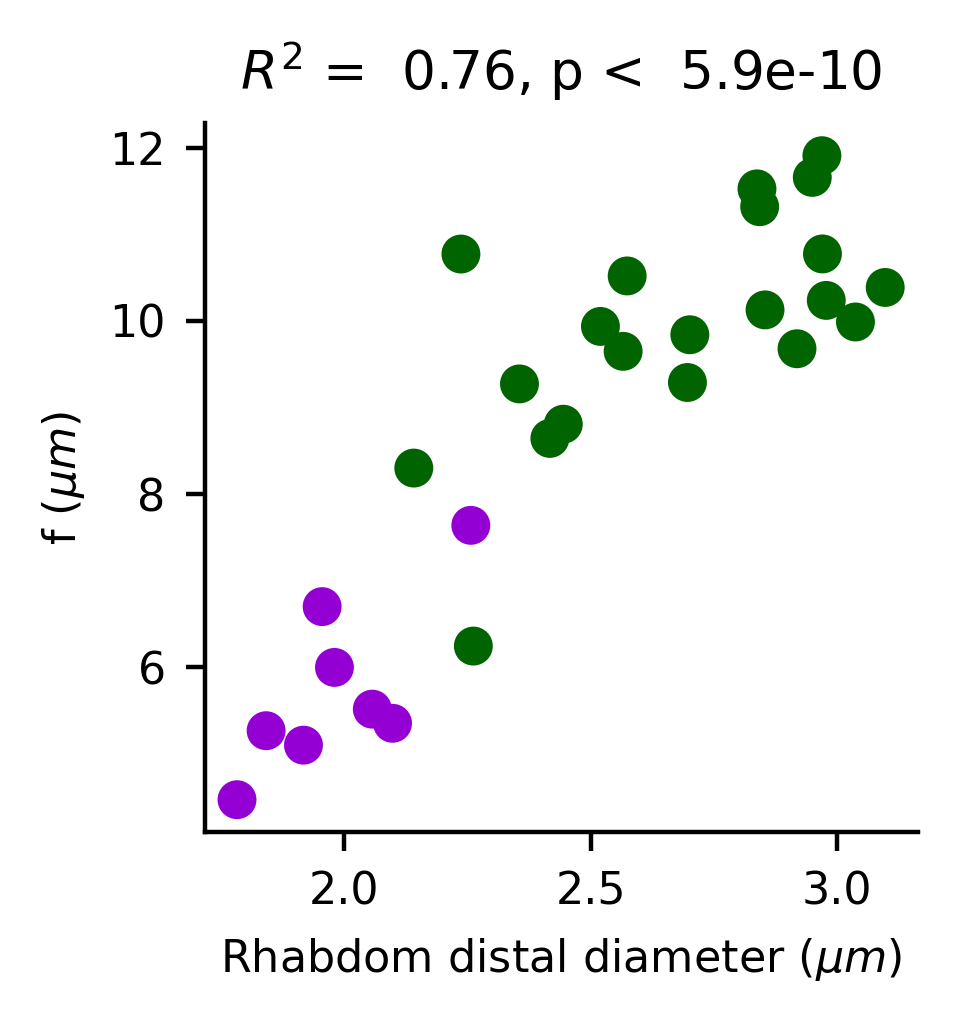

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                f-image   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     87.36
Date:                Tue, 15 Jun 2021   Prob (F-statistic):           5.93e-10
Time:                        17:00:51   Log-Likelihood:                -43.318
No. Observations:                  29   AIC:                             90.64
Df Residuals:                      27   BIC:                             93.37
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -3.2208      1.302     -2.475      0.020      -5.891      -0.550
D rhabdom dist.     4.8199      0.516      9.346      0.000       3.762       5.878
==============================================================================
Omnibus:                        4.234   Durbin-Watson:                   1.870
Prob(Omnibus):                  0.120   Jarque-Bera (JB):                2.693
Skew:                           0.687   Prob(JB):                        0.260
Kurtosis:                       3.584   Cond. No.                         18.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
_x = optics_df['D rhabdom dist.'] 
X = sm.add_constant(_x)
Y = optics_df['f-image']

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params)
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

c = []
for om in optics_df.index:
    if om in dra_om:
        c.append('darkviolet')
    else:
        c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c=c, marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel('Rhabdom distal diameter ($\mu{m}$)')
ax.set_ylabel("f ($\mu{m}$)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
#ax.plot(xx, params['const'] + params['D rhabdom dist.'] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/Drh_f_rhabdom_scatter_fullscale.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/Drh_f_rhabdom_scatter_fullcale.png')

# SHOW OLS RESULTS
display(results.summary())

const                    -1.013818
facet diameter (stack)    0.985829
dtype: float64

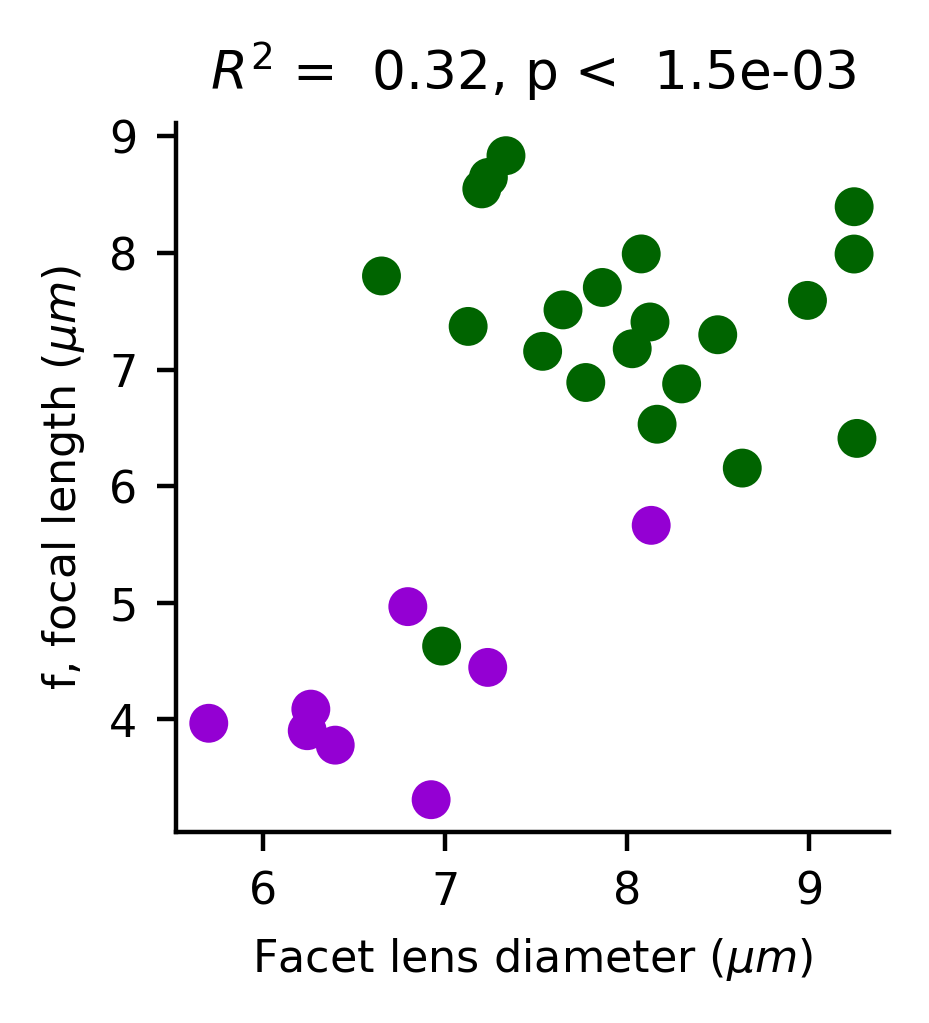

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      f   R-squared:                       0.317
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     12.55
Date:                Tue, 15 Jun 2021   Prob (F-statistic):            0.00146
Time:                        17:00:51   Log-Likelihood:                -50.053
No. Observations:                  29   AIC:                             104.1
Df Residuals:                      27   BIC:                             106.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -1.0138      2.142     -0.473      0.640      -5.409       3.382
facet diameter (stack)     0.9858      0.278      3.543      0.001       0.415       1.557
==============================================================================
Omnibus:                        1.310   Durbin-Watson:                   1.201
Prob(Omnibus):                  0.520   Jarque-Bera (JB):                1.219
Skew:                           0.375   Prob(JB):                        0.544
Kurtosis:                       2.333   Cond. No.                         64.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
_x = D
X = sm.add_constant(_x)
Y = optics_df['f']

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params)
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

c = []
for om in optics_df.index:
    if om in dra_om:
        c.append('darkviolet')
    else:
        c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c=c, marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel('Facet lens diameter ($\mu{m}$)')
ax.set_ylabel("f, focal length ($\mu{m}$)")

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
#ax.plot(xx, params['const'] + params['D rhabdom dist.'] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/Drh_f_rhabdom_scatter_fullscale.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/Drh_f_rhabdom_scatter_fullcale.png')

# SHOW OLS RESULTS
display(results.summary())

const    2.312958
f       -0.164509
dtype: float64

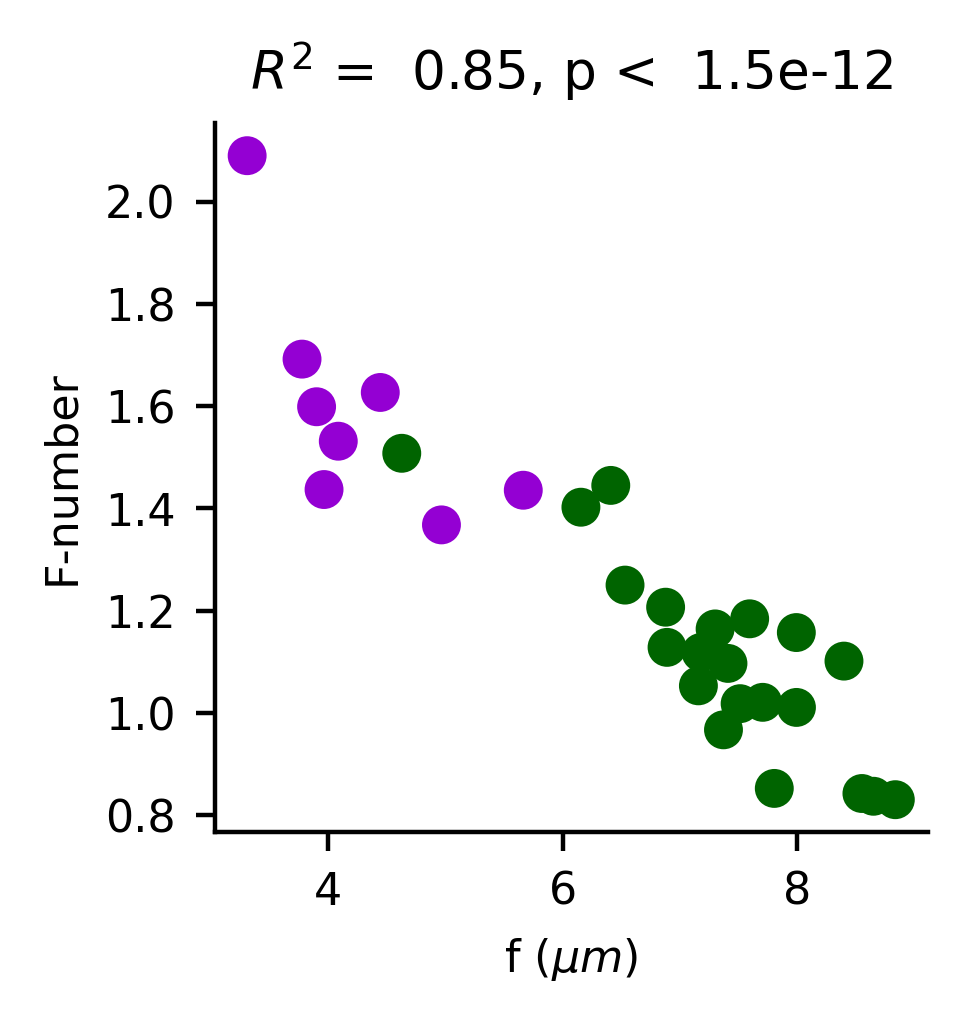

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               F-number   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                     150.2
Date:                Tue, 15 Jun 2021   Prob (F-statistic):           1.53e-12
Time:                        17:00:51   Log-Likelihood:                 21.630
No. Observations:                  29   AIC:                            -39.26
Df Residuals:                      27   BIC:                            -36.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3130      0.090     25.623      0.000       2.128       2.498
f             -0.1645      0.013    -12.254      0.000      -0.192      -0.137
==============================================================================
Omnibus:                        3.866   Durbin-Watson:                   1.373
Prob(Omnibus):                  0.145   Jarque-Bera (JB):                2.362
Skew:                           0.633   Prob(JB):                        0.307
Kurtosis:                       3.594   Cond. No.                         28.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
_x = optics_df['f']
X = sm.add_constant(_x)
Y = optics_df['F-number']

model = sm.OLS(Y, X)
results = model.fit()
params = results.params
display(params)
# ~~~
fig, ax = plt.subplots(1, figsize=[2.3, 2.3])

c = []
for om in optics_df.index:
    if om in dra_om:
        c.append('darkviolet')
    else:
        c.append('darkgreen')

#ax.scatter(x=optics_df['cone length (from the tip)'] + optics_df['lense thickness'], y=optics_df["f-image"], c=c)
ax.scatter(x=_x, y=Y, c=c, marker='o')
ax.set_title(f'$R^{2}$ = {results.rsquared: .2f}, p < {results.f_pvalue: .1e}')
ax.set_xlabel("f ($\mu{m}$)")
ax.set_ylabel('F-number')

#xx = np.arange(min(_x), max(_x))
xx = np.arange(0, max(_x))
#ax.plot(xx, params['const'] + params['D rhabdom dist.'] * xx, c='k', ls='--')

plt.show()

if save_figs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/Drh_f_rhabdom_scatter_fullscale.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/Drh_f_rhabdom_scatter_fullcale.png')

# SHOW OLS RESULTS
display(results.summary())

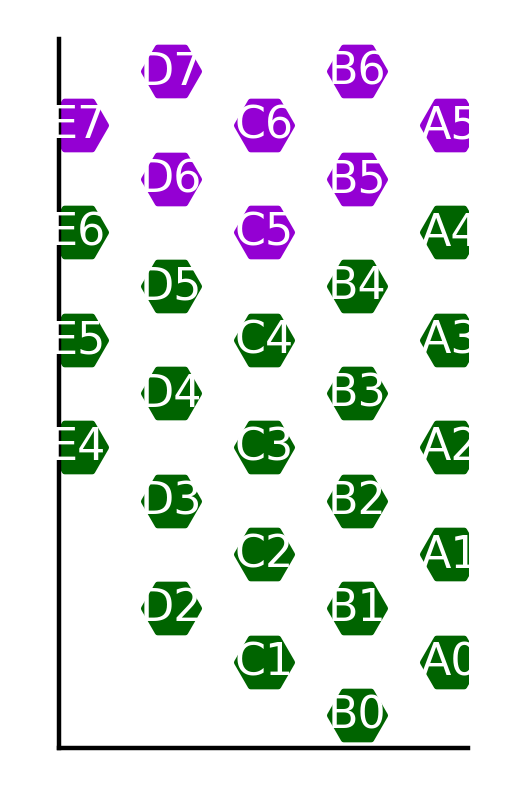

In [11]:
fig, ax = plt.subplots(1, frameon=False)#figsize=(3.2, 3.2))
#fig.tight_layout()
hexplot_TEST(node_data={k: {'colour': v} for k, v in zip(optics_df.index, c)}, ax=ax, lc='w')
plt.show()
#fig.savefig(fig.savefig("/mnt/home/nchua/Dropbox/200610_clus-assign.svg"))
if save_figs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/dra_ndra.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/dra_ndra.png')

/mnt/home/nchua/src/cx-analysis/vis/fig_tools.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  clist = np.array([min_colour, max_colour])


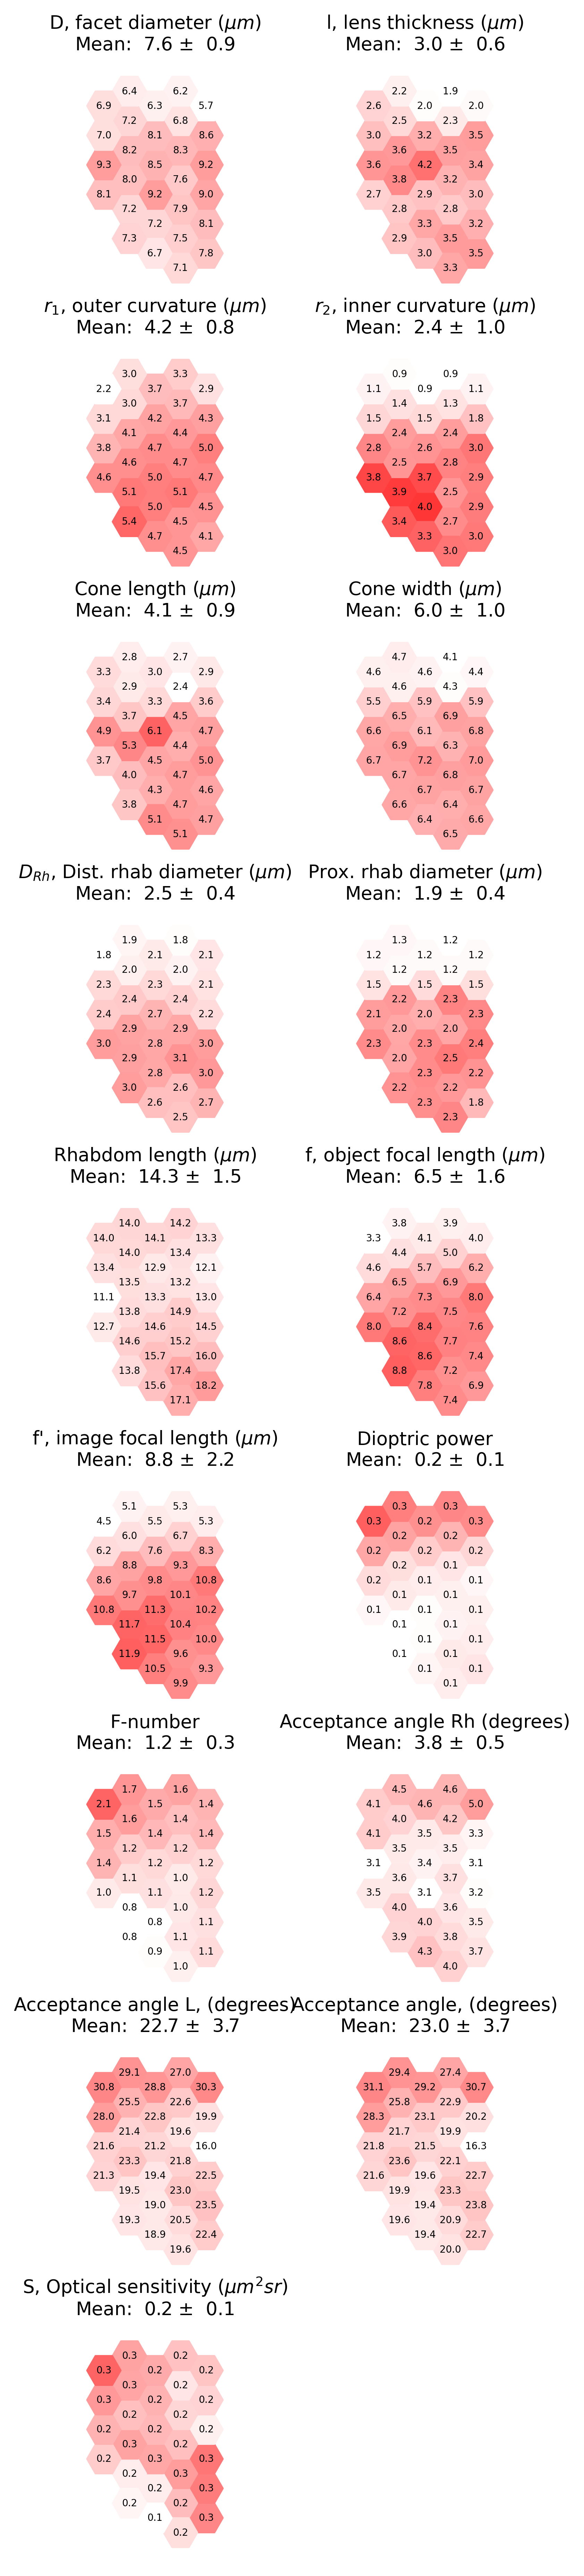

In [12]:
fig, ax = plt.subplots(9, 2, figsize=(4.6, 9.0*2.6))
axes = ax.flatten()
lincm = linear_cmap(n_vals=100, max_colour='r')

param_labels = ['D, facet diameter ($\mu{m}$)', 'l, lens thickness ($\mu{m}$)', '$r_1$, outer curvature ($\mu{m}$)',
               '$r_2$, inner curvature ($\mu{m}$)', 'Cone length ($\mu{m}$)', 'Cone width ($\mu{m}$)', '$D_{Rh}$, Dist. rhab diameter ($\mu{m}$)', 
               'Prox. rhab diameter ($\mu{m}$)', 'Rhabdom length ($\mu{m}$)', 'f, object focal length ($\mu{m}$)', "f', image focal length ($\mu{m}$)",
               'Dioptric power', 'F-number', 'Acceptance angle Rh (degrees)', 'Acceptance angle L, (degrees)', 'Acceptance angle, (degrees)', 
               'S, Optical sensitivity ($\mu{m}^2 sr$)']


i = 0
for param, vals in optics_df.iteritems():
    max_val = vals.max()
    min_val = vals.min()
    
    node_data = {om: {'label': np.round(v, decimals=1),
                      'colour': lincm((v-min_val)/max_val)} for om, v in vals.items()}
    hexplot(node_data, ax=axes[i])
    axes[i].set_title(f"{param_labels[i]}\n" + 
                      f"Mean: {vals.mean(): .1f} $\pm$ {vals.std(ddof=0): .1f}")
    i += 1
axes[-1].set_visible(False)
plt.show()

if save_figs:
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/optic_params_hex.svg')
    fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/optic_params_hex.png')

In [13]:
fig, ax = plt.subplots(3, 2, figsize=(24, 33))
axes = ax.flatten()
labels = ['focal length of lens (\u03BCm)', 'focal length in image plane (\u03BCm)',
         'lens power', 'F-number', 'acceptance angle (degrees)',
         'Airy disk half-width (\u03BCm)']

i = 0
for param, vals in optics_df.iloc[:, -6:].iteritems():
    max_val = vals.max()
    node_data = {om: {'label': np.round(v, decimals=2),
                     'colour': lincm(v/max_val)} for om, v in vals.items()}
    hexplot(node_data, ax=axes[i])
    axes[i].set_title(f"{labels[i]}")
    # TO CHECK IF LABELS AND PARAMS LINE UP
    #axes[i].set_title(f"{labels[i]}\n{param}")
    i += 1
    

In [14]:
tp = '200507'
linkdf = pd.read_pickle(f'~/Data/{tp}_lamina/{tp}_linkdf.pickle')

cxvecs = assemble_cxvectors(linkdf)
thresh = cxvecs.mean()>1.0
cxvecs = cxvecs.loc[:, thresh]
homevecs = cxvecs.loc[:, [i for i in cxvecs.columns if '->e' not in i]]

display(homevecs)

,LMC_2->LMC_1,LMC_2->LMC_2,LMC_2->LMC_3,LMC_2->LMC_4,LMC_2->R2R5,LMC_2->R7,LMC_2->R7p,LMC_2->R8,LMC_2->centri,LMC_N->LMC_1,...,centri->LMC_2,centri->LMC_3,centri->LMC_4,centri->R1R4,centri->R2R5,centri->R3R6,centri->R7,centri->R7p,centri->R8,centri->centri
A0,20,0,3,18,0,1,6,0,6,3,...,13,14,2,3,18,1,5,15,23,3
A1,33,12,12,33,6,1,10,4,1,4,...,11,9,4,2,14,1,1,22,13,1
A2,18,5,13,21,4,0,10,4,0,3,...,7,6,4,0,8,0,0,15,11,0
A3,24,4,16,17,0,0,4,1,7,4,...,37,18,3,0,19,0,7,32,26,4
A4,26,1,17,25,0,2,6,1,3,2,...,29,13,11,1,28,0,18,27,15,5
A5,20,5,5,16,2,3,3,1,8,0,...,14,8,9,1,27,3,15,17,8,2
B0,24,3,4,0,6,3,18,7,3,0,...,10,9,0,1,10,0,0,16,12,0
B1,18,1,5,9,2,1,6,4,18,2,...,19,15,2,2,26,2,4,29,22,3
B2,25,0,9,17,1,0,2,4,1,16,...,22,21,5,2,27,2,0,37,18,4
B3,21,4,17,23,0,1,3,5,0,2,...,21,17,7,0,20,0,3,23,11,0


In [15]:
# combined connectivity and optics into one df 
combined = homevecs.join(optics_df)
assert(all(combined.notna())) # should not contain any NaNs
#display(combined)

47 connection types


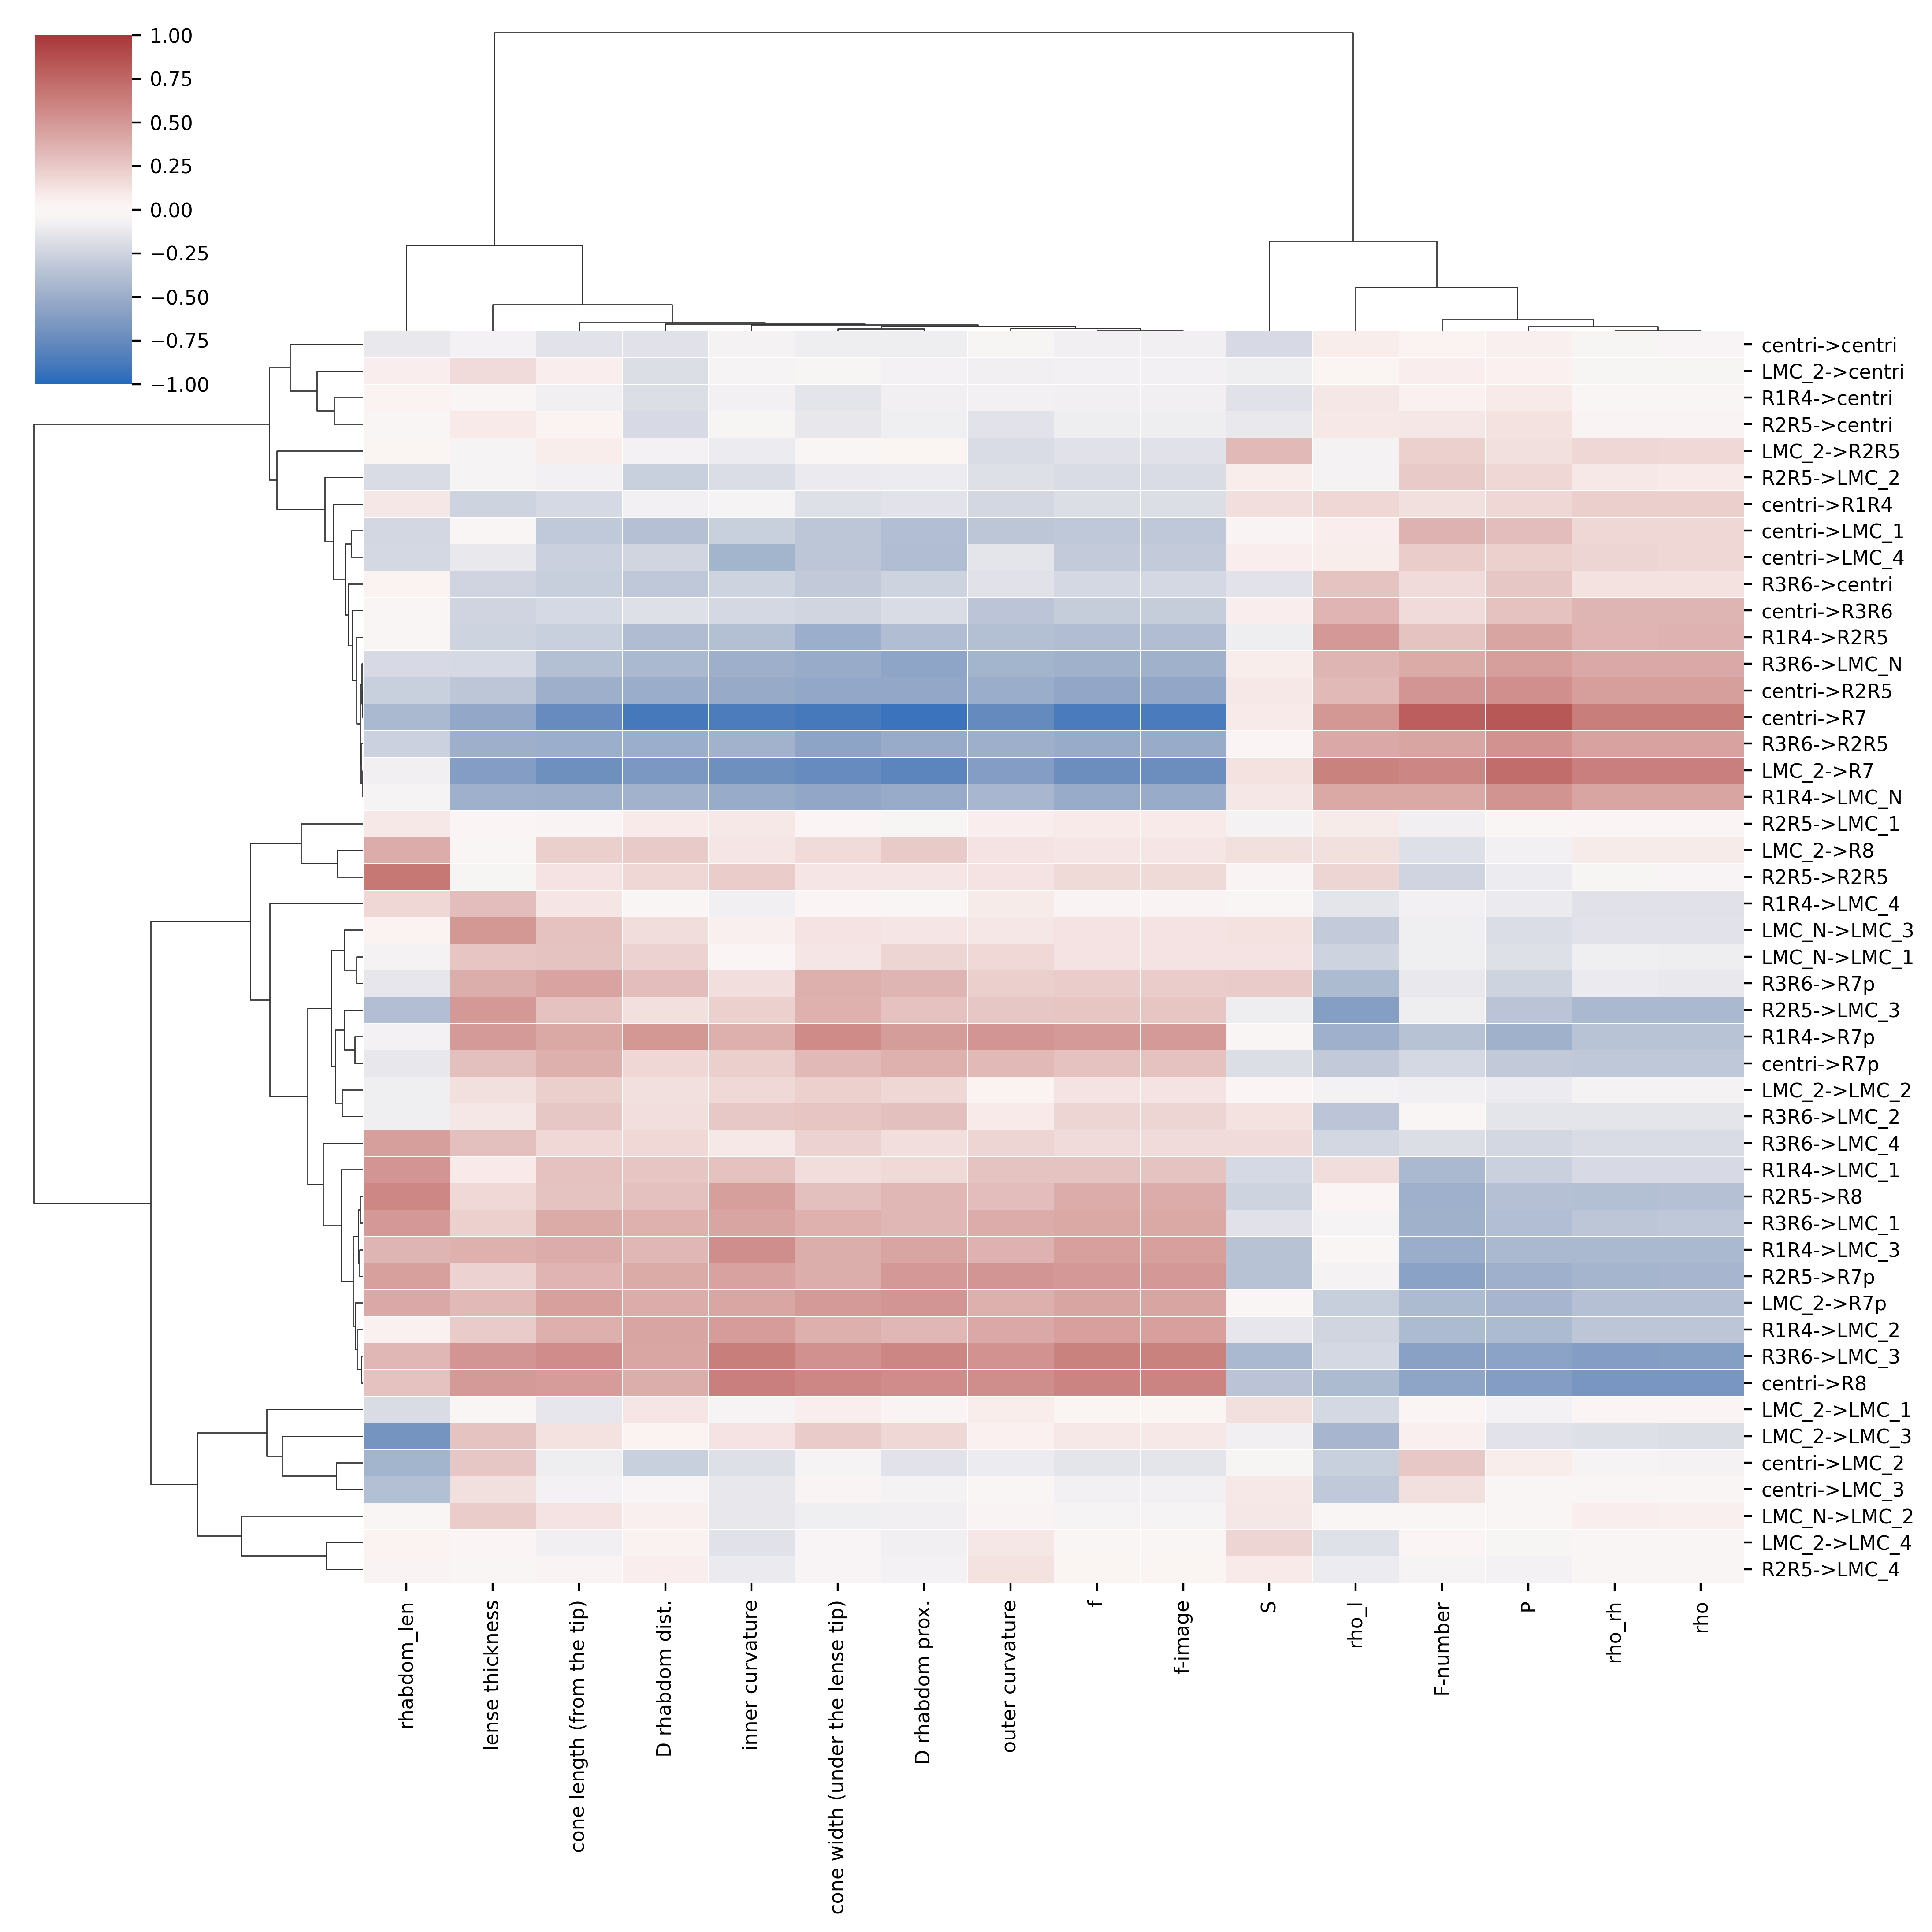

In [16]:

print(f"{len(homevecs.columns)} connection types")

all_corr = combined.corr()
cx_v_optics = all_corr.filter(items=homevecs.columns, axis=0).filter(items=optics_df.columns, axis=1)
#display(cx_v_optics)

clus = sns.clustermap(cx_v_optics, 
                      linewidth=0.1,
                      figsize=[11, 11], metric='cosine', 
                      cmap='vlag', vmax=1.0, vmin=-1.0)

#row_colors = [cm[x.split('->')[0]] for x in cx_corr.index]

In [17]:
fig, ax = plt.subplots(1)
r7_totals = 
sns.regplot()

SyntaxError: invalid syntax (<ipython-input-17-f0c4f523a5a8>, line 2)